<a href="https://colab.research.google.com/github/AdelinRovay/CSE_575_HW/blob/main/S24_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys; sys.path.append('../..') ; sys.path.append('..') ; from my_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# dummy trainloader
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1, shuffle=True)
device = torch.device('cpu')

import matplotlib.pyplot as plt

In this homework, we build a neural network for performing binary classification. We will base our implementation on neural ordinary differential equations (NODEs). We will again use the concentric annuli dataset.

Let's begin by importing some libaries.

Next, we set a random seed for reproducibility.

In [ ]:
import numpy as np
import random

seed = 0
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

# Concentric annuli



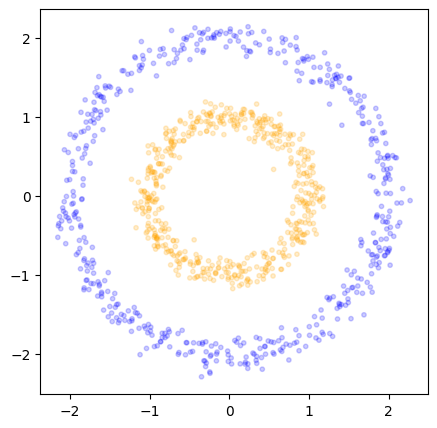

In [ ]:
Xtrain, ytrain = sample_annuli()
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_scatter(ax, Xtrain, ytrain)

First, lets see how a simple shallow neural network would perform.

In [ ]:
class Model(nn.Module):
    def __init__(self,device="cpu"):
        super(Model, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,50),
            nn.Tanh(),
            nn.Linear(50,1))
        #for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, x):
        y = self.net(x)
        y = torch.sigmoid(y)
        return y

In [ ]:
model = Model().to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [ ]:
for itr in range(1, 501):
    optimizer.zero_grad()
#    x0, y = sample_annuli(device=device, n_samples=1024)

    yh = model(Xtrain)
    loss = nn.BCELoss()(yh.squeeze(), ytrain.float())
    if itr%50==0:
      print(itr,loss.item())
    #loss_traj[itr-1] = loss.item()
    loss.backward()
    optimizer.step()

50 0.0011410395381972194
100 0.0004529255093075335
150 0.00031520603806711733
200 0.00022963662922848016
250 0.0001735023979563266
300 0.00013539806241169572
350 0.00010857399320229888
400 8.900414104573429e-05
450 7.427829405060038e-05
500 6.291117460932583e-05


You can see that the model can easily achieve zero error.

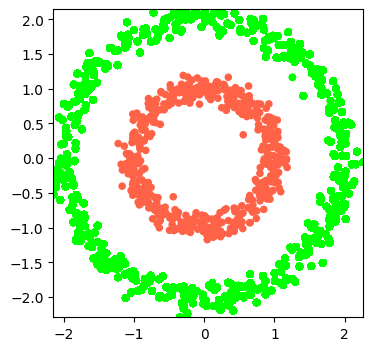

tensor(0)


In [ ]:
with torch.no_grad():
    fig = plt.figure(figsize=(4,4))
    axes = []
    axes.append(fig.add_subplot(1,1,1))#,sharex=True,sharey=True))
    xs, ys = Xtrain, ytrain#sample_gaussian(n_samples=200) ; s = torch.linspace(0, 1, 10)

    y_pred = model(xs)

    label = (y_pred[:,0] >= 0.5).long()

    colors = ['lime','tomato']
    for i in range(512):
        axes[0].scatter(xs[i,0], xs[i,1], c=colors[label[i]], edgecolor='none', s=30)
        axes[0].scatter(xs[i+512:,0], xs[i+512:,1], c=colors[label[i+512]], edgecolor='none', s=30)
    axes[0].set_xlim(xs[:,0].min(), xs[:,0].max()) ; axes[0].set_ylim(xs[:,1].min(), xs[:,1].max())
    plt.show()
    err = torch.sum(torch.abs(label) - torch.abs(ytrain))
    print(err)



# NODEs

Now, lets implement neural ODEs for the binary classification.

First, you need to install a proper API, torchdiffeq (https://github.com/rtqichen/torchdiffeq)

In [ ]:
!pip3 install torchdiffeq

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from torchdiffeq import odeint

In the following (the ODEFunc class), we define the right-hand side of the neural ODEs ($f$ in the equation below).

$$ \frac{d x}{d t} = f(x;\theta) $$

In [ ]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            nn.Linear(2, hdim),
            nn.Tanh(),
            nn.Linear(hdim, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

    def forward(self, t, y):
        return self.net(y)

The model below solves the initial value problem associated with the NODE defined above starting at $t=0$ to the terminal time $t=1$.

In [ ]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return torch.sigmoid(yhat)


In [ ]:
def dec_bound(model, x):
    P = [p for p in model.linear_layer.parameters()]
    w1, w2, b = P[0][0][0].cpu().detach(), P[0][0][1].cpu().detach(), P[1][0].cpu().detach().item()
    return (-w1*x - b + .5)/w2

1 0.6931472420692444
2 0.6930838823318481
3 0.6930156946182251
4 0.6929415464401245
5 0.6928609013557434
6 0.6927733421325684
7 0.6926784515380859
8 0.6925758123397827
9 0.6924648880958557
10 0.6923452019691467
11 0.6922160387039185
12 0.6920764446258545
13 0.6919259428977966
14 0.6917632818222046
15 0.6915879249572754
16 0.6913984417915344
17 0.6911941170692444
18 0.690973699092865
19 0.6907362937927246
20 0.6904802918434143
21 0.6902046799659729
22 0.6899080872535706
23 0.6895890831947327
24 0.6892460584640503
25 0.6888774037361145
26 0.6884815096855164
27 0.688056468963623
28 0.687600314617157
29 0.6871110796928406
30 0.6865864992141724
31 0.6860243082046509
32 0.6854220628738403
33 0.6847771406173706
34 0.684087336063385
35 0.6833497285842896
36 0.6825621724128723
37 0.6817222237586975
38 0.6808276772499084
39 0.6798765659332275
40 0.6788672208786011
41 0.6777979731559753
42 0.6766676902770996
43 0.6754754781723022
44 0.6742209196090698
45 0.672903835773468
46 0.6715248227119446
47

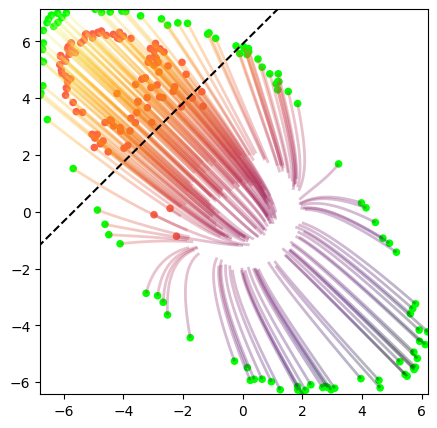

101 0.5769915580749512
102 0.5754978656768799
103 0.5740126371383667
104 0.5725376605987549
105 0.5710737705230713
106 0.569621205329895
107 0.5681794881820679
108 0.5667475461959839
109 0.5653244256973267
110 0.5639088153839111
111 0.5624998807907104
112 0.5610966682434082
113 0.5596985816955566
114 0.5583049058914185
115 0.556914746761322
116 0.5555270314216614
117 0.5541403293609619
118 0.5527534484863281
119 0.5513647198677063
120 0.5499728918075562
121 0.5485768914222717
122 0.5471758246421814
123 0.5457690358161926
124 0.5443563461303711
125 0.542937695980072
126 0.5415130853652954
127 0.5400827527046204
128 0.538646936416626
129 0.5372061133384705
130 0.5357604622840881
131 0.5343104004859924
132 0.5328564047813416
133 0.5313988327980042
134 0.5299379825592041
135 0.5284740924835205
136 0.527006983757019
137 0.5255366563796997
138 0.5240626335144043
139 0.522584080696106
140 0.5211005210876465
141 0.5196110606193542
142 0.5181151628494263
143 0.5166122317314148
144 0.51510202884

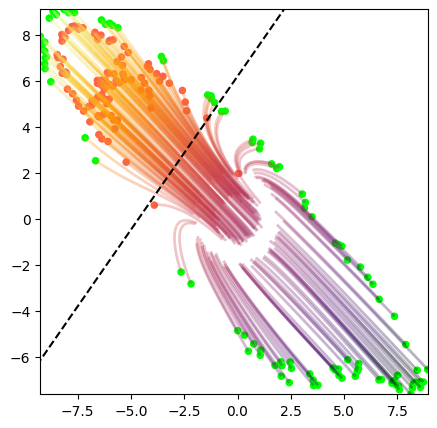

201 0.40785789489746094
202 0.4056793749332428
203 0.4035155177116394
204 0.4013667106628418
205 0.3992336392402649
206 0.39711642265319824
207 0.3950141668319702
208 0.3929254412651062
209 0.3908484876155853
210 0.38878172636032104
211 0.38672342896461487
212 0.38467225432395935
213 0.38262689113616943
214 0.3805868327617645
215 0.3785518407821655
216 0.3765209913253784
217 0.374492883682251
218 0.37246641516685486
219 0.3704410791397095
220 0.36841684579849243
221 0.3663921654224396
222 0.3643642067909241
223 0.36232990026474
224 0.3602864146232605
225 0.35822969675064087
226 0.3561534881591797
227 0.3540509045124054
228 0.3519198000431061
229 0.34976911544799805
230 0.3476095199584961
231 0.3454369306564331
232 0.3432444930076599
233 0.3410351574420929
234 0.33881324529647827
235 0.33657485246658325
236 0.3343118131160736
237 0.3320196270942688
238 0.3297002911567688
239 0.3273565173149109
240 0.32498931884765625
241 0.32259899377822876
242 0.32018303871154785
243 0.3177391886711120

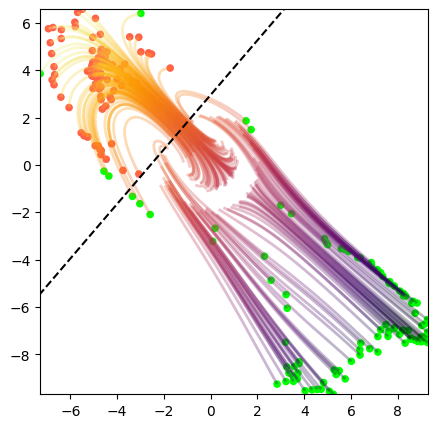

301 0.1609542816877365
302 0.15915615856647491
303 0.15738257765769958
304 0.15562793612480164
305 0.15389123558998108
306 0.15216439962387085
307 0.15044903755187988
308 0.14873500168323517
309 0.14702868461608887
310 0.14532996714115143
311 0.14365154504776
312 0.141992449760437
313 0.14034803211688995
314 0.13871881365776062
315 0.1371113657951355
316 0.13553248345851898
317 0.1340278834104538
318 0.13270016014575958
319 0.13214057683944702
320 0.12946049869060516
321 0.12915290892124176
322 0.12934115529060364
323 0.12721829116344452
324 0.1247764304280281
325 0.1248546689748764
326 0.1227244958281517
327 0.12349633127450943
328 0.12004242837429047
329 0.11968645453453064
330 0.11862596124410629
331 0.11645825207233429
332 0.1166766881942749
333 0.1148475706577301
334 0.11339469999074936
335 0.1133354976773262
336 0.11128971725702286
337 0.11095714569091797
338 0.11003125458955765
339 0.10850478708744049
340 0.10825765132904053
341 0.10692857950925827
342 0.10609458386898041
343 0.

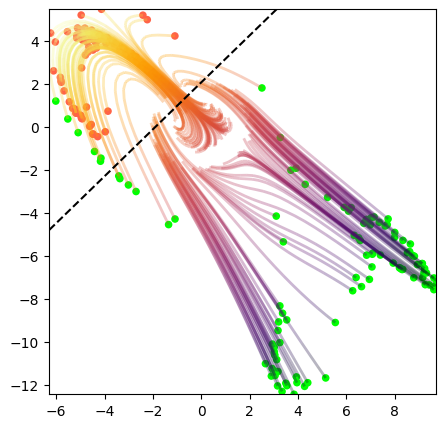

401 0.07183842360973358
402 0.07142608612775803
403 0.0710311159491539
404 0.07065421342849731
405 0.07026022672653198
406 0.06987882405519485
407 0.06951827555894852
408 0.06913851946592331
409 0.06877200305461884
410 0.06842365115880966
411 0.06805737316608429
412 0.06770674884319305
413 0.0673665851354599
414 0.06701557338237762
415 0.06668410450220108
416 0.06634511053562164
417 0.06601372361183167
418 0.06569145619869232
419 0.06536176800727844
420 0.06504777818918228
421 0.0647265613079071
422 0.06441351771354675
423 0.06410694122314453
424 0.06379660964012146
425 0.06349287927150726
426 0.06319419294595718
427 0.06289513409137726
428 0.0625995546579361
429 0.06230749934911728
430 0.06201646849513054
431 0.06172952428460121
432 0.06144370138645172
433 0.06116226315498352
434 0.06088109686970711
435 0.060603827238082886
436 0.06032719835639
437 0.06005316972732544
438 0.059781815856695175
439 0.05951128154993057
440 0.05924363434314728
441 0.058977123349905014
442 0.05871326848864

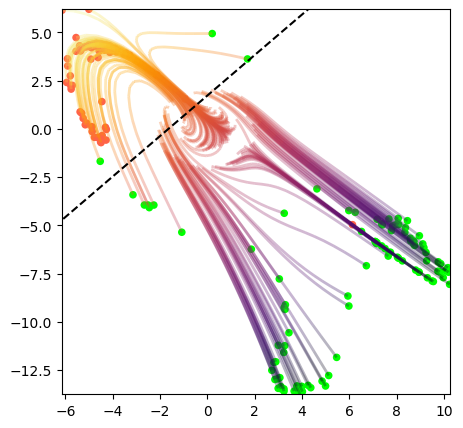

In [ ]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(yh[-1], ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()

            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)
#            ax.scatter(xS[-1,:,-2], xS[-1,:,-1], c='lime', edgecolor='none', s=30)
#            ax.scatter(xS[0,:,-2], xS[0,:,-1], c='black', alpha=.5, s=30)
            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()


In [ ]:
label = (yh[1,:,0] >= 0.5).long()

In [ ]:
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)

tensor(0.0156)


<b>[Questions]</b>

You can see that the neural ODEs fail to achieve 100% accuracy. This is somewhat odd considering that the simple shallow network could achieve 100% accuracy and NODEs are an advanced version of ResNets.

[3 pts] Can you explain why NODEs (by design) fail and are not suitable for performing this task?

**Answer:** In the case of NODE, the movement of one point can not overlap with the trajectory of another point. At the point of overlap, the vectors of both the points will follow the same trajectory. In the case of our data set, the Circular Annuli Data, one set of data points are enclosed within another. This might be causing the overlap in trajectories and hence NODEs are not able to classify.

[4 pts] now implement variants of NODEs that overcome the issue of NODEs shown above. Any variant of NODE will be accepted. The resulting model should achieve 100% accuracy. Following is the one such variant. See the implementation below (Not all parts of the implementation is revealed; I removed one important block myDepthCat.)

In [ ]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            myDepthCat(1),
            nn.Linear(2+1, hdim),
            nn.Tanh(),
            myDepthCat(1),
            nn.Linear(hdim+1, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

        #for p in self.net[-1].parameters(): torch.nn.init.zeros_(p)

    def forward(self, t, y):
        for _, module in self.net.named_modules():
            if hasattr(module, 't'):
                module.t = t
        return self.net(y)


#Concatenate depth info to the input
class myDepthCat(nn.Module):
    def __init__(self, additional_dim):
        super(myDepthCat, self).__init__()
        self.t = None
        self.dim_add = additional_dim
    def forward(self, x):
        time = torch.ones(x.size(0), self.dim_add).to(x.device) * self.t  #Concatenating time along the specified dimension
        return torch.cat((x, time), dim=1)


In [ ]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return yhat


1 0.6931472420692444
2 0.6931009888648987
3 0.6930516362190247
4 0.6929983496665955
5 0.692940890789032
6 0.6928789019584656
7 0.6928120255470276
8 0.6927399635314941
9 0.6926623582839966
10 0.6925788521766663
11 0.6924890875816345
12 0.6923923492431641
13 0.6922881603240967
14 0.6921758651733398
15 0.6920547485351562
16 0.6919237375259399
17 0.6917822360992432
18 0.6916290521621704
19 0.6914631724357605
20 0.6912834644317627
21 0.6910887360572815
22 0.6908777356147766
23 0.6906490325927734
24 0.6904011964797974
25 0.6901324987411499
26 0.6898413896560669
27 0.6895262002944946
28 0.6891847848892212
29 0.6888154745101929
30 0.688416063785553
31 0.6879847049713135
32 0.6875191926956177
33 0.6870173215866089
34 0.6864770650863647
35 0.6858961582183838
36 0.6852725744247437
37 0.6846040487289429
38 0.683888852596283
39 0.6831248998641968
40 0.6823107600212097
41 0.6814452409744263
42 0.6805272698402405
43 0.6795567870140076
44 0.6785336136817932
45 0.6774585843086243
46 0.6763328313827515


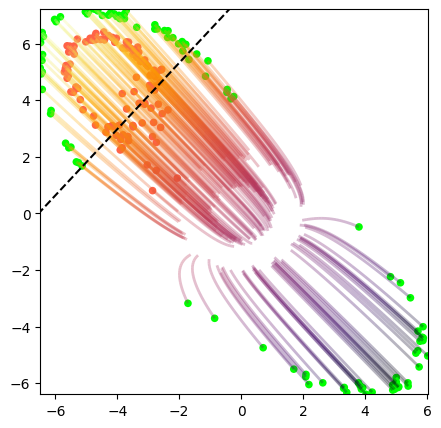

101 0.6087754368782043
102 0.6075774431228638
103 0.6063762903213501
104 0.6051710844039917
105 0.6039589643478394
106 0.6027364730834961
107 0.6015000939369202
108 0.6002475023269653
109 0.5989779233932495
110 0.5976930856704712
111 0.5963961482048035
112 0.5950919389724731
113 0.5937851071357727
114 0.5924789905548096
115 0.5911758542060852
116 0.5898757576942444
117 0.588577389717102
118 0.5872786641120911
119 0.5859773755073547
120 0.5846719145774841
121 0.5833611488342285
122 0.5820444822311401
123 0.5807213187217712
124 0.579391598701477
125 0.5780550241470337
126 0.5767116546630859
127 0.5753616094589233
128 0.5740050077438354
129 0.5726420879364014
130 0.5712736248970032
131 0.5699001550674438
132 0.5685224533081055
133 0.5671417713165283
134 0.5657589435577393
135 0.564375102519989
136 0.562991201877594
137 0.5616083145141602
138 0.5602272748947144
139 0.5588488578796387
140 0.55747389793396
141 0.5561029314994812
142 0.5547367334365845
143 0.5533754825592041
144 0.55201971530

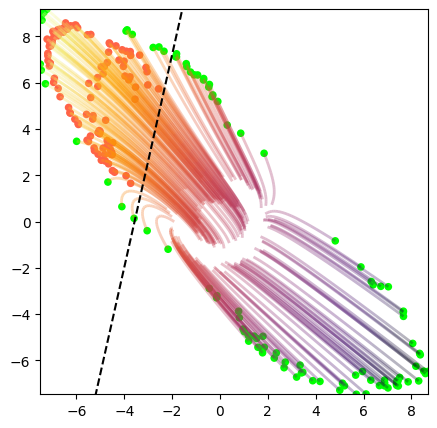

201 0.4686492085456848
202 0.46669042110443115
203 0.4647437334060669
204 0.4627892076969147
205 0.4608074724674225
206 0.45878708362579346
207 0.4567206799983978
208 0.45460304617881775
209 0.45243024826049805
210 0.45019951462745667
211 0.4479100704193115
212 0.4455645680427551
213 0.4431677758693695
214 0.4407235085964203
215 0.4382321834564209
216 0.435691773891449
217 0.43309909105300903
218 0.4304496943950653
219 0.4277392625808716
220 0.42496389150619507
221 0.42212072014808655
222 0.41920721530914307
223 0.4162203073501587
224 0.41315728425979614
225 0.4100172817707062
226 0.40680158138275146
227 0.403514564037323
228 0.40016382932662964
229 0.39675843715667725
230 0.3933066725730896
231 0.38981500267982483
232 0.3862888514995575
233 0.38273313641548157
234 0.37915295362472534
235 0.37555304169654846
236 0.37193721532821655
237 0.36830833554267883
238 0.36466798186302185
239 0.3610166311264038
240 0.3573538362979889
241 0.35367855429649353
242 0.3499893546104431
243 0.346285074

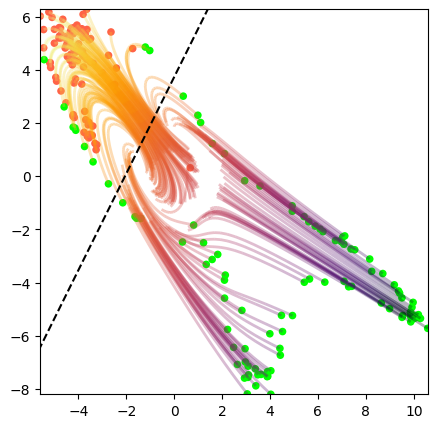

301 0.14363804459571838
302 0.14122343063354492
303 0.13886027038097382
304 0.13654863834381104
305 0.1342872530221939
306 0.13207414746284485
307 0.1299094557762146
308 0.12779060006141663
309 0.12571778893470764
310 0.12368902564048767
311 0.12170366942882538
312 0.11976054310798645
313 0.11785828322172165
314 0.1159963458776474
315 0.11417309939861298
316 0.11238817870616913
317 0.11063990741968155
318 0.10892782360315323
319 0.10725031793117523
320 0.10560684651136398
321 0.10399608314037323
322 0.10241726040840149
323 0.10086926817893982
324 0.09935122728347778
325 0.09786215424537659
326 0.0964011400938034
327 0.09496728330850601
328 0.09355972707271576
329 0.09217763692140579
330 0.09082016348838806
331 0.08948654681444168
332 0.08817597478628159
333 0.08688767999410629
334 0.08562099188566208
335 0.08437518775463104
336 0.08314961940050125
337 0.08194361627101898
338 0.08075655251741409
339 0.07958784699440002
340 0.07843691855669022
341 0.07730313390493393
342 0.07618600130081

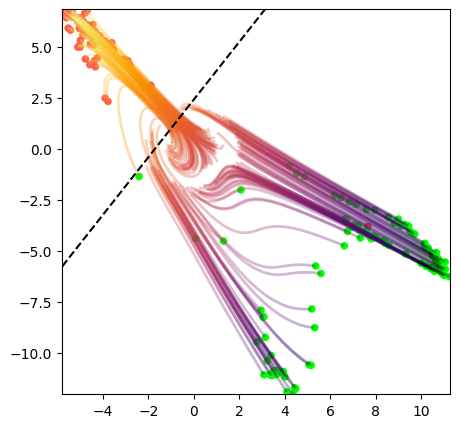

401 0.02677077241241932
402 0.026202863082289696
403 0.025650445371866226
404 0.025112882256507874
405 0.02458949014544487
406 0.02407975122332573
407 0.02358316257596016
408 0.023099403828382492
409 0.02262817695736885
410 0.022169288247823715
411 0.021722588688135147
412 0.021287988871335983
413 0.02086545340716839
414 0.020454930141568184
415 0.02005632035434246
416 0.01966949924826622
417 0.01929423213005066
418 0.01893024891614914
419 0.01857721246778965
420 0.01823480613529682
421 0.017902620136737823
422 0.017580261453986168
423 0.017267366871237755
424 0.016963522881269455
425 0.016668356955051422
426 0.016381490975618362
427 0.016102569177746773
428 0.015831228345632553
429 0.015567146241664886
430 0.015309974551200867
431 0.015059436671435833
432 0.01481524296104908
433 0.014577214606106281
434 0.01434517465531826
435 0.014118989929556847
436 0.013898525387048721
437 0.013683621771633625
438 0.013474149629473686
439 0.013269905932247639
440 0.013070756569504738
441 0.01287651

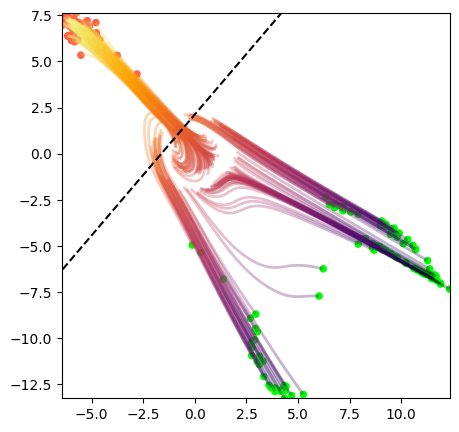

In [ ]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(torch.sigmoid(yh[-1]), ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()
            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)

            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()


In [ ]:
label = (yh[1,:,0] >= 0.5).long()
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)

tensor(0.)


In [ ]:
accuracy = (label==ytrain).sum()/1024
print("Model Accuracy is: ", accuracy.item())

Model Accuracy is:  1.0
